### Objective: Given reviews in text, visualize datapoints using t-SNE after vectorizing each text review using 
   * ### BoW
   * ### TF-IDF 
   * ### AvgW2V 
   * ### TF-IDFW2V

### Motivation: Given a review, to build a model which determines whether the review is positive or negative.

### Dataset: Amazon Fine Food Reviews

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

### Premise:

[Q] How to determine if a review is positive or negative?<br>[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

### Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, we use the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# [1]. Reading the data

In [2]:
## finding the contents of the database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///database.sqlite')
print(engine.table_names())

['Reviews']


* So, the reviews data is stored in the database with the table name 'Reviews'

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

# For our objective of visulaization, I'm taking just 6000 data points from the original data 
# I make sure that the taken data has an equal proportion of negative and positive reviews
positive_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score > 3 LIMIT 3000""", con)
negative_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score < 3 LIMIT 3000""", con)
amazon_filtered_data = pd.concat([positive_data,negative_data])

# changing reviews with score less than 3 to be positive and vice-versa
amazon_filtered_data['Score'] = amazon_filtered_data.Score.apply(lambda x:'positive' if x>3 else 'negative')
print("Number of data points in our data", amazon_filtered_data.shape)

# shuffling the data
amazon_filtered_data = amazon_filtered_data.sample(frac=1,random_state=0).reset_index(drop=True)
amazon_filtered_data.head(10)

Number of data points in our data (6000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,8677,B003VXFK44,AMEEXXHSFDS3Z,Tito Lover,1,5,negative,1287360000,Yuk! Twangy aftertaste and weak coffee make t...,I bought both the Creme Caramel and this Hazel...
1,2594,B000EGX2EG,A2T0LGPLQY2GW,J. Burk,0,1,positive,1181779200,Great Almond Crunch!!,My husband and both love almonds. I've even sh...
2,18478,B000BZ6LXO,A16YFQH7UYHVOF,"Michigander ""twizz1233""",0,0,negative,1344211200,Not impressed.,I bought this for all my deck containers this ...
3,605,B000G6RYNE,A2TMSO255FQBBU,Brian H. Goldberg,1,1,positive,1218758400,Some of the best chips anywhere,Kettle chips are thicker and crunchier (though...
4,1736,B001RVFDOO,A2VHZIBAVLU8OL,debbie723,0,0,positive,1280188800,Pop Chips are great,When I found these chips I was shocked to see ...
5,1853,B001RVFDOO,A305JULQXPH8S7,Salvatore Grieco,1,1,positive,1300060800,My new favorite chips!,I love chips and can easily go through an enti...
6,19161,B000I6PXGM,A2HVL44J1CMMJD,"Lucy Fan ""Kari""",0,0,negative,1198886400,Not much taste,I was very disappointed that this coffee did n...
7,3219,B005K4Q1VI,A1LFVTK70U5EZ5,GQ,0,0,negative,1347321600,Sweet cocoa,I found this too sweet. Am hoping there's an u...
8,1469,B0040WHJQM,A2SNRIDC4QCCXN,"Sinead NiC ""American & Irish expat""",0,0,positive,1346457600,"Great for a healthy, hot, great-tasting vegan ...",There are many workdays when I only have a few...
9,160,B000ITVLE2,A395S4RA1X7BFB,Pen_Name123,3,3,positive,1315872000,Simple but good,I've never heard of the SAFCOL brand before bu...


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication


 ***Motivation : Based on the text of the review, determine whether it is positive or negative.***

* So, we need unique data points i.e.,unique review in text form to build an efficient model.

* First, we can check for any duplicates with all the columns if existing and remove them.


In [4]:
amazon_filtered_data[amazon_filtered_data.duplicated(subset=None, keep='first')].shape

(0, 10)

* So there are no duplicates with all the feature values being same for an instant

#### Now

* From the definition of Helpfulness numerator and denominator, it requires Helpfulness numerator to be less than Helpfulness denominator.
* We check for any anomalies as such and remove them if existing.

In [5]:
amazon_filtered_data[amazon_filtered_data.HelpfulnessNumerator > amazon_filtered_data.HelpfulnessDenominator].shape

(0, 10)

In [6]:
amazon_dedup1_data= amazon_filtered_data[amazon_filtered_data.HelpfulnessNumerator <= amazon_filtered_data.HelpfulnessDenominator]
amazon_dedup1_data.shape

(6000, 10)

### Now
* Also, we could check for a given product, each user could review only once at an instant.

In [7]:
amazon_dedup1_data[amazon_dedup1_data.duplicated(subset = {"UserId","ProfileName","Time","Text"})].shape

(127, 10)

In [8]:
amazon_dedup1_data[amazon_dedup1_data.duplicated(subset = {"UserId","ProfileName","Time","Text"})].head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
368,9386,B006N3IG4K,AMEEXXHSFDS3Z,Tito Lover,1,5,negative,1287360000,Yuk! Twangy aftertaste and weak coffee make t...,I bought both the Creme Caramel and this Hazel...
580,15044,B0000CDBRY,A253F3QA4WHGXU,"Robert Hefferle ""HEFF""",1,3,negative,1319155200,Vegetable seasoning very spicy,Paul Prudhomme makes great seafood seasoning a...
668,13325,B004286RC6,A2YDDLVUX7UHVT,dragonhaven,5,8,negative,1317513600,See's Truffles through Amazon,I have already communicated with the See's com...
749,8400,B003VXFK44,A35UWJL3AGIHBM,Adam N. Rubenstein,0,0,negative,1335139200,Not good at all!!!!!!!!!!!!!,This flavor is horrible. There are many other...
891,9331,B006N3IG4K,ALMBZNEFJT6VZ,Wrena,0,0,negative,1290556800,yuck,This was the nastiest flavored coffee I have e...


In [9]:
check = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AMEEXXHSFDS3Z"
ORDER BY ProductID
""", con)
print(check.shape)
check.head()


(18, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,493173,B003TC7WN4,AMEEXXHSFDS3Z,Tito Lover,4,4,2,1287360000,Just blah...,It seems the flavor selection on Amazon has be...
1,493239,B003TC7WN4,AMEEXXHSFDS3Z,Tito Lover,1,5,1,1287360000,Yuk! Twangy aftertaste and weak coffee make t...,I bought both the Creme Caramel and this Hazel...
2,8611,B003VXFK44,AMEEXXHSFDS3Z,Tito Lover,4,4,2,1287360000,Just blah...,It seems the flavor selection on Amazon has be...
3,8677,B003VXFK44,AMEEXXHSFDS3Z,Tito Lover,1,5,1,1287360000,Yuk! Twangy aftertaste and weak coffee make t...,I bought both the Creme Caramel and this Hazel...
4,536020,B003VXHGDM,AMEEXXHSFDS3Z,Tito Lover,4,4,2,1287360000,Just blah...,It seems the flavor selection on Amazon has be...


* We could see from the above that the user 'Tito Lover' has reviewed different products (B003TC7WN4 and B003VXFK44) at the same instant and text being the same.  
* And there are 127 such redundant data points w.r.t different user in our sample data.

***We can remove them to reduce redundancy *** 

In [10]:
#Sorting data according to ProductId in ascending order
#to make the dedup process faster
amazon_sorted_data = amazon_dedup1_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
amazon_dedup2_data = amazon_sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
amazon_dedup2_data.shape

(5873, 10)

*** Moreover, since we intend to build a model only based on 'Text' feature, we can extend the above idea and remove any repeating text if exists.***

In [11]:
amazon_final_data = amazon_dedup2_data.drop_duplicates(subset={"Text"}, keep='first', inplace=False)


In [12]:
#Checking to see how much % of data still remains
(amazon_final_data['Id'].size*1.0)/(amazon_filtered_data['Id'].size*1.0)*100

97.85000000000001

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(amazon_final_data.shape)

amazon_final_data.shape
#How many positive and negative reviews are present in our dataset?
amazon_final_data['Score'].value_counts()

(5871, 10)


positive    2993
negative    2878
Name: Score, dtype: int64

# [3].  Text Preprocessing.

In the Preprocessing phase we follow the below guidelines generally used for text preprocessing, before converting text to vector for further analysis.

1. Begin by removing any urls and html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>



In [14]:
# printing some random reviews

sent_22 = amazon_final_data['Text'].values[93]
print(sent_22)
print("="*50)

sent_205= amazon_final_data['Text'].values[205]
print(sent_205)
print("="*50)

sent_813=amazon_final_data['Text'].values[813]
print(sent_813)
print("="*50)


I purchased this sauce as it is the exact same sauce used at the hot sauce bar of Tijuana Flats (http://www.tijuanaflats.com/).  It goes amazing with steak tostadas but in my home cooking, it works wells as a marinade and as a condiment.
SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEASE GIVE REAL FOOD TO HUNGRY PEOPLE,<br /><br />What's in Kellogg's Corn Flakes? "Milled Corn, Sugar, Malt Flavoring, High Fructose Corn Syrup, Salt." Yes, of course, it also has lots of yummy preservatives such as BHT and a few synthetic vitamins and iron in minute quantities. For nutrition you get basically 100% Carbs from lots of SUGAR and almost NO PROTEIN. Add skim milk, or you'll get saturated fat with a little protein from whole milk. For added nutrition, include a sliced banana and a capful of wheat germ.<br /><br />If you like Corn Flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than 0.29 cents an ounce [$3.49 per package]. At

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_22 = re.sub(r"http\S+", "", sent_22)
print(sent_22)
print("="*50)


I purchased this sauce as it is the exact same sauce used at the hot sauce bar of Tijuana Flats (  It goes amazing with steak tostadas but in my home cooking, it works wells as a marinade and as a condiment.


* We could see that the url in the review sent_22 has been removed.

### Now,
* We try to remove all the html tags(< />) from the above texts and try to get only cleaned text using Beautiful Soup module.

In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# we use here an lxml's HTML parser since its a bit faster than the python's HTML parser

soup = BeautifulSoup(sent_22, 'lxml')
sent_22 = soup.get_text()
print(sent_22)
print("="*50)

soup = BeautifulSoup(sent_205, 'lxml')
sent_205 = soup.get_text()
print(sent_205)
print("="*50)

soup = BeautifulSoup(sent_813, 'lxml')
sent_813 = soup.get_text()
print(sent_813)
print("="*50)


I purchased this sauce as it is the exact same sauce used at the hot sauce bar of Tijuana Flats (  It goes amazing with steak tostadas but in my home cooking, it works wells as a marinade and as a condiment.
SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEASE GIVE REAL FOOD TO HUNGRY PEOPLE,What's in Kellogg's Corn Flakes? "Milled Corn, Sugar, Malt Flavoring, High Fructose Corn Syrup, Salt." Yes, of course, it also has lots of yummy preservatives such as BHT and a few synthetic vitamins and iron in minute quantities. For nutrition you get basically 100% Carbs from lots of SUGAR and almost NO PROTEIN. Add skim milk, or you'll get saturated fat with a little protein from whole milk. For added nutrition, include a sliced banana and a capful of wheat germ.If you like Corn Flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than 0.29 cents an ounce [$3.49 per package]. At this price, the inner package's failure to maintain f

* Now, to make the text cleaner and containg only words, we can try expand all the contractions(such as expanding "wasn't" to "was not") in the reviews. 

In [17]:
# https://stackoverflow.com/a/47091490/4084039

#modified to account for uppercase letters.

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase.lower())
    phrase = re.sub(r"can\'t", "can not", phrase.lower())

    # general
    phrase = re.sub(r"n\'t", " not", phrase.lower())
    phrase = re.sub(r"\'re", " are", phrase.lower())
    phrase = re.sub(r"\'s", " is", phrase.lower())
    phrase = re.sub(r"\'d", " would", phrase.lower())
    phrase = re.sub(r"\'ll", " will", phrase.lower())
    phrase = re.sub(r"\'t", " not", phrase.lower())
    phrase = re.sub(r"\'ve", " have", phrase.lower())
    phrase = re.sub(r"\'m", " am",phrase.lower())
    return phrase

* Although the above code has some short comings like "Jack's going" vs "Jack's work"(output with above code would be " Jack is going" vs "Jack is work"), we can see that it doesn't affect much since "is" is included in English stopwords.

In [18]:
print(sent_205)

SOMETHING TO EAT IF YOU'RE STARVING - BUT PLEASE GIVE REAL FOOD TO HUNGRY PEOPLE,What's in Kellogg's Corn Flakes? "Milled Corn, Sugar, Malt Flavoring, High Fructose Corn Syrup, Salt." Yes, of course, it also has lots of yummy preservatives such as BHT and a few synthetic vitamins and iron in minute quantities. For nutrition you get basically 100% Carbs from lots of SUGAR and almost NO PROTEIN. Add skim milk, or you'll get saturated fat with a little protein from whole milk. For added nutrition, include a sliced banana and a capful of wheat germ.If you like Corn Flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than 0.29 cents an ounce [$3.49 per package]. At this price, the inner package's failure to maintain freshness is an even bigger drawback when one thinks of how long it may take to finish 12 ounces of this stuff. Why not use a vacuum-sealed container like Kretschmer's Wheat Germ to preserve freshness? After a

In [19]:
sent_205 = decontracted(sent_205)
print(sent_205)
print("="*50)


something to eat if you are starving - but please give real food to hungry people,what is in kellogg is corn flakes? "milled corn, sugar, malt flavoring, high fructose corn syrup, salt." yes, of course, it also has lots of yummy preservatives such as bht and a few synthetic vitamins and iron in minute quantities. for nutrition you get basically 100% carbs from lots of sugar and almost no protein. add skim milk, or you will get saturated fat with a little protein from whole milk. for added nutrition, include a sliced banana and a capful of wheat germ.if you like corn flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than 0.29 cents an ounce [$3.49 per package]. at this price, the inner package is failure to maintain freshness is an even bigger drawback when one thinks of how long it may take to finish 12 ounces of this stuff. why not use a vacuum-sealed container like kretschmer is wheat germ to preserve freshness? 

In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_205 = re.sub("\S*\d\S*", "", sent_205).strip()
print(sent_205)

something to eat if you are starving - but please give real food to hungry people,what is in kellogg is corn flakes? "milled corn, sugar, malt flavoring, high fructose corn syrup, salt." yes, of course, it also has lots of yummy preservatives such as bht and a few synthetic vitamins and iron in minute quantities. for nutrition you get basically  carbs from lots of sugar and almost no protein. add skim milk, or you will get saturated fat with a little protein from whole milk. for added nutrition, include a sliced banana and a capful of wheat germ.if you like corn flakes, that is your business and you should enjoy them, but this is not health food and it is a very poor value for more than  cents an ounce  per package]. at this price, the inner package is failure to maintain freshness is an even bigger drawback when one thinks of how long it may take to finish  ounces of this stuff. why not use a vacuum-sealed container like kretschmer is wheat germ to preserve freshness? after all, it is

In [21]:
#remove words that are not letters or numbers  https://stackoverflow.com/a/5843547/4084039
sent_205 = re.sub('[^A-Za-z0-9]+', ' ', sent_205)
print(sent_205)

something to eat if you are starving but please give real food to hungry people what is in kellogg is corn flakes milled corn sugar malt flavoring high fructose corn syrup salt yes of course it also has lots of yummy preservatives such as bht and a few synthetic vitamins and iron in minute quantities for nutrition you get basically carbs from lots of sugar and almost no protein add skim milk or you will get saturated fat with a little protein from whole milk for added nutrition include a sliced banana and a capful of wheat germ if you like corn flakes that is your business and you should enjoy them but this is not health food and it is a very poor value for more than cents an ounce per package at this price the inner package is failure to maintain freshness is an even bigger drawback when one thinks of how long it may take to finish ounces of this stuff why not use a vacuum sealed container like kretschmer is wheat germ to preserve freshness after all it is in the same price range so i

In [22]:
# https://gist.github.com/sebleier/554280
# Removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above steps 
#sno = nltk.stem.SnowballStemmer('english')

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(amazon_final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    #for e in sentence.split():
        #sentence = ' '.join(sno.stem(e))
    preprocessed_reviews.append(sentence.strip())

100%|████████████████████████████████████| 5871/5871 [00:02<00:00, 2122.62it/s]


In [27]:
## Finally Stemming the words

sno = nltk.stem.SnowballStemmer('english')
from tqdm import tqdm
preprocessed_reviews_stem = []
# tqdm is for printing the status bar
for sentence in tqdm(preprocessed_reviews):
    filtered_sentence = []
    for words in sentence.split():
        s=(sno.stem(words))
        filtered_sentence.append(s)
        #sentence = ' '.join(sno.stem(e))
    str_stemmed = ' '.join(filtered_sentence)
    preprocessed_reviews_stem.append(str_stemmed)

100%|█████████████████████████████████████| 5871/5871 [00:05<00:00, 994.18it/s]


In [28]:
preprocessed_reviews[150]

'good thing chipotle flavor generally smoked jalapenos bit milder flavorful regular raw jalapenos not case powder chili chipotle powder hot hot hot seriously lacking flavor thing extremely fine grind sprinkle sauce enough enters air end inhaling feels like burning nose yuck stick plain old generic chili powder instead'

In [29]:
preprocessed_reviews_stem[150]

'good thing chipotl flavor general smoke jalapeno bit milder flavor regular raw jalapeno not case powder chili chipotl powder hot hot hot serious lack flavor thing extrem fine grind sprinkl sauc enough enter air end inhal feel like burn nose yuck stick plain old generic chili powder instead'

* I intend to use the unstemmed reviews for further processing, since,given a transformer like Word2Vec, to find a vector for a word, it is easy to give the general word as input rather than the stemmed word. 

# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandoned', 'abates', 'abby', 'abc', 'abdomen', 'abdominal', 'abide']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5871, 14868)
the number of unique words  14868


## [4.2] Bi-Grams and n-Grams

In [31]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams

count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (5871, 3843)
the number of unique words including both unigrams and bigrams  3843


## [4.3] TF-IDF

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'accept']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5871, 3843)
the number of unique words including both unigrams and bigrams  3843


## [4.4] Word2Vec

In [33]:
# Creating text corpus suitable for applying Word2Vec and hence training our own model
i=0
list_of_sentence=[]
for sentence in preprocessed_reviews:
    list_of_sentence.append(sentence.split())    

In [34]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))

[('salty', 0.9890798330307007), ('tasty', 0.9875370264053345), ('regular', 0.9871764183044434), ('crunchy', 0.9864543080329895), ('overly', 0.9853894710540771), ('buds', 0.9851935505867004), ('pretty', 0.9851751923561096), ('pronounced', 0.9851549863815308), ('texture', 0.9850465059280396), ('describe', 0.9848858714103699)]
[('mahogany', 0.9979826211929321), ('french', 0.9979604482650757), ('earl', 0.997790515422821), ('grey', 0.9975236058235168), ('coffees', 0.9974504709243774), ('starbucks', 0.9973468780517578), ('drinker', 0.9973326921463013), ('mustard', 0.997237503528595), ('brewing', 0.9972161054611206), ('teas', 0.9972031116485596)]


In [35]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4479
sample words  ['product', 'available', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'use', 'car', 'windows', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'everybody', 'asks']


In [36]:
len(w2v_words)

4479

## [4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50 (we defined it above)
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████| 5871/5871 [00:07<00:00, 768.93it/s]


5871
50


In [38]:
sent_vectors[0]

array([ 0.13986443, -0.32905559,  0.0839648 ,  0.15569394, -0.06162367,
       -0.35494658, -0.349129  , -0.1704602 ,  0.39488774, -0.26017467,
       -0.46649311, -0.48082387,  0.43551859, -0.14307521, -0.26527399,
        0.04576686,  0.45530702,  0.49593198, -0.57838785, -0.50520498,
       -0.66531748, -0.15518975,  0.36008927,  0.44446588,  0.32785157,
        0.12268131, -0.01107962,  0.08956372, -0.1561662 ,  0.17313281,
       -0.21163147, -0.40848456,  0.15393201, -0.29035895, -0.2455873 ,
        0.45654938,  0.02235804,  0.14324007, -0.48301597,  0.10608581,
        0.17094897,  0.21166089, -0.10010956, -0.06497104,  0.28299828,
        0.14879643, -0.65261449, -0.06014545, -0.2406535 , -0.52637394])

In [39]:
print(type(sent_vectors))
print(type(sent_vectors[0]))

<class 'list'>
<class 'numpy.ndarray'>


In [40]:
sent_vectors_arr = np.array(sent_vectors)
sent_vectors_mat = np.asmatrix(sent_vectors_arr)
type(sent_vectors_mat)

numpy.matrixlib.defmatrix.matrix

#### [4.4.1.2] TFIDF weighted W2v

In [41]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 5871/5871 [00:47<00:00, 122.42it/s]


In [43]:
print(type(tfidf_sent_vectors))
print(type(tfidf_sent_vectors[0]))

<class 'list'>
<class 'numpy.ndarray'>


In [44]:
tfidf_sent_vectors_arr =np.array(tfidf_sent_vectors)
tfidf_sent_vectors_mat = np.asmatrix(tfidf_sent_vectors_arr)
type(tfidf_sent_vectors_mat)

numpy.matrixlib.defmatrix.matrix

# [5] Applying t-SNE

* Since, t-SNE is a memory intensive problem, I'm taking top 4000 data points from our sampled data for the following analysis.

## [5.1] Applying t-SNE on Text BOW vectors

In [45]:
# Since t-SNE accepts only dense matrices and BoW tansformer gives sparse output,
#we convert BoW output to dense matrices.
final_counts_dense = final_counts.todense()

# Standardizing the columns before applying t-SNE technique
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_std=True)
scaler.fit(final_counts_dense)
scaler.transform(final_counts_dense)

array([[-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212],
       [-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212],
       [-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212],
       ..., 
       [-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212],
       [-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212],
       [-0.01305212, -0.01305212, -0.01846005, ..., -0.01846005,
        -0.01305212, -0.01305212]])

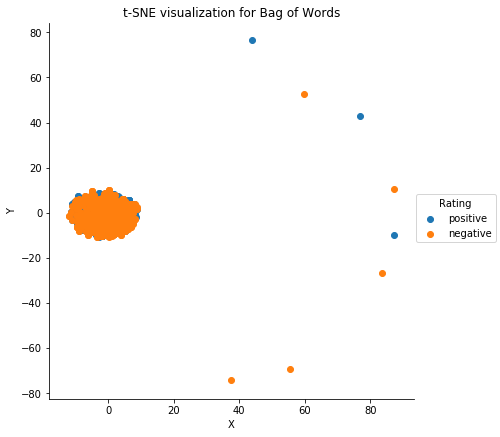

640.375485420227


In [46]:
import time
start = time.time()

from sklearn.manifold import TSNE

# configuring the parameteres
# the number of components = 2 (The no. of dimensions in which we want to visulaize)
# perplexity = 30 (30 datapoints are considered in a neighbourhood)
# Maximum number of iterations for the optimization = 4000
# init='pca' initializing the t-SNE to use the first two principal components from PCA on the input data, 
# rescaled to have the same standard deviation as the gaussian distribution from the random initialization (0.0001). 

model = TSNE(n_components=2, random_state=0,perplexity= 30.0,n_iter=4000,init='pca')
tsne_data = model.fit_transform(final_counts_dense[0:4000,:])


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, amazon_final_data['Score'][0:4000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X", "Y", "Rating"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'X', 'Y').add_legend()
plt.title("t-SNE visualization for Bag of Words")
plt.show()

end = time.time()
print(end - start)

## Observations:
* Although positive and negative reviews are grouped together per class, both the groups are completely overlapping making it difficult to have a linear separation between them.

## [5.2] Applying t-SNE on Text TFIDF vectors


In [47]:
# Since t-SNE accepts only dense matrices and TFIDF tansformer gives sparse output,
#we convert its output to dense matrices.
final_tf_idf_dense = final_tf_idf .todense()

# Standardizing the columns before applying t-SNE technique
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_std=True)
scaler.fit(final_tf_idf_dense)
scaler.transform(final_tf_idf_dense)

array([[-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ],
       [-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ],
       [-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ],
       ..., 
       [-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ],
       [-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ],
       [-0.04046513, -0.13901085, -0.05380162, ..., -0.06389709,
        -0.04166701, -0.0409456 ]])

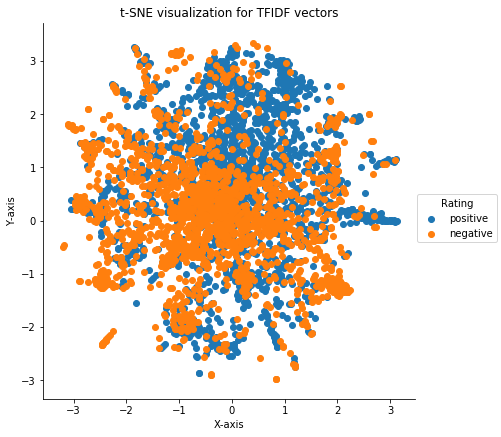

217.22415256500244


In [48]:
import time
start = time.time()

from sklearn.manifold import TSNE

# configuring the parameteres
# the number of components = 2 (The no. of dimensions in which we want to visulaize)
# perplexity = 30 (30 datapoints are considered in a neighbourhood)
# Maximum number of iterations for the optimization = 4000
# init='pca' initializing the t-SNE to use the first two principal components from PCA on the input data, 
# rescaled to have the same standard deviation as the gaussian distribution from the random initialization (0.0001). 
model = TSNE(n_components=2, random_state=0,perplexity= 30.0,n_iter=4000,init='pca')
tsne_data = model.fit_transform(final_tf_idf_dense[0:4000,:])

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, amazon_final_data['Score'][0:4000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X-axis", "Y-axis", "Rating"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, "X-axis", "Y-axis").add_legend()
plt.title("t-SNE visualization for TFIDF vectors")
plt.show()
end = time.time()
print(end - start)

## Observations:
* Positive and Negative reviews are scattered all around and are overlapping in some regions.

## [5.3] Applying t-SNE on Text Avg W2V vectors

In [49]:
# Standardizing the columns before applying t-SNE technique
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_std=True)
scaler.fit(sent_vectors)
scaler.transform(sent_vectors)

array([[-1.09552276,  1.36609701,  0.7095536 , ..., -0.54598348,
         0.332679  ,  1.11367686],
       [-1.10989088,  0.64522452, -0.10092322, ..., -0.36768487,
         1.07366291,  1.18983987],
       [-0.95980016,  1.48400631,  0.3925037 , ..., -0.2200107 ,
         1.24280488,  1.42309728],
       ..., 
       [ 0.72051656,  0.20383883, -0.83864239, ...,  1.01089568,
         0.53930238, -1.02198836],
       [-0.23761367,  0.30705656,  0.43135607, ..., -0.11831391,
        -0.12771659,  0.14709882],
       [ 0.28839659, -0.91248749, -0.79575498, ...,  0.13777709,
         0.74983157, -0.39459872]])

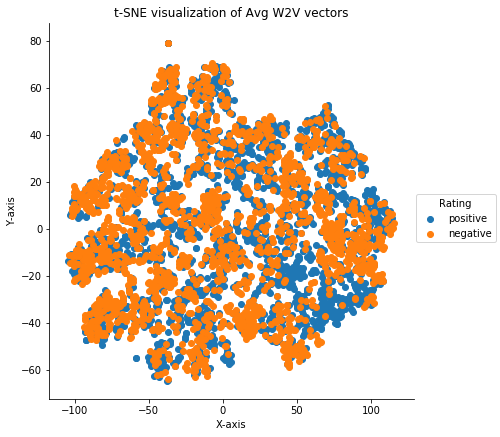

207.2652883529663


In [50]:
import time
start = time.time()

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity= 30.0,n_iter=4000,init='pca')
# configuring the parameteres
# the number of components = 2 (The no. of dimensions in which we want to visulaize)
# perplexity = 30 (30 datapoints are considered in a neighbourhood)
# Maximum number of iterations for the optimization = 4000
# init='pca' initializing the t-SNE to use the first two principal components from PCA on the input data, 
# rescaled to have the same standard deviation as the gaussian distribution from the random initialization (0.0001). 

tsne_data = model.fit_transform(sent_vectors[0:4000])

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, amazon_final_data['Score'][0:4000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X-axis", "Y-axis", "Rating"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, "X-axis", "Y-axis").add_legend()
plt.title("t-SNE visualization of Avg W2V vectors")
plt.show()
end = time.time()
print(end - start)

## Observations:
* Positive and negative reviews are overlapping.

## [5.4] Applying TNSE on Text TFIDF weighted W2V vectors

In [51]:
# Standardizing the columns before applying t-SNE technique
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(copy=True, with_std=True)
scaler.fit(tfidf_sent_vectors)
scaler.transform(tfidf_sent_vectors)

array([[-0.90496062,  1.21810206,  0.44516141, ..., -0.35185201,
         0.75804758,  1.02098416],
       [-1.15687113,  1.50685243,  0.05824223, ..., -0.19099579,
         1.5546711 ,  1.533837  ],
       [-1.09731838,  1.72200907,  0.38661366, ..., -0.27340188,
         1.3840561 ,  1.54511415],
       ..., 
       [ 0.63107372,  0.05986783, -0.72815656, ...,  0.80590979,
         0.40644724, -0.77521661],
       [-0.36547333,  0.40808539,  0.49204716, ..., -0.1812998 ,
         0.01483627,  0.32597346],
       [ 0.10184009, -0.97218409, -0.75063471, ..., -0.06013347,
         0.66930513, -0.21491099]])

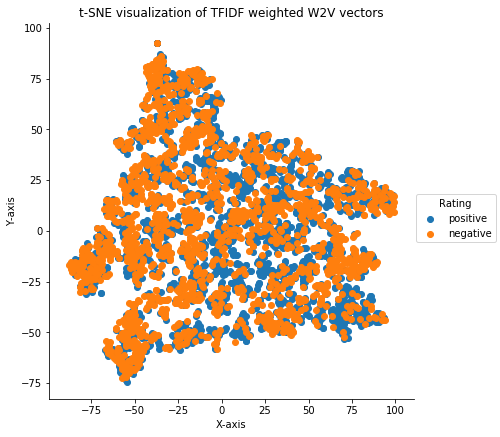

174.89123487472534


In [52]:
import time
start = time.time()

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity= 30.0,n_iter=4000,init='pca')

# configuring the parameteres
# the number of components = 2 (The no. of dimensions in which we want to visulaize)
# perplexity = 30 (30 datapoints are considered in a neighbourhood)
# Maximum number of iterations for the optimization = 4000
# init='pca' initializing the t-SNE to use the first two principal components from PCA on the input data, 
# rescaled to have the same standard deviation as the gaussian distribution from the random initialization (0.0001). 

tsne_data = model.fit_transform(tfidf_sent_vectors[0:4000])

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, amazon_final_data['Score'][0:4000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("X-axis", "Y-axis", "Rating"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter,"X-axis", "Y-axis").add_legend()
plt.title("t-SNE visualization of TFIDF weighted W2V vectors")
plt.show()

end = time.time()
print(end - start)

## Observations:
* Positive and negative reviews are overlapping similar to Avg W2V featurization.

# [6] Conclusion:

* Of all the featurizations, Bag of Words is the least helpful as it seems to gives the same vector representation for both positive and negative reviews and hence the overlapping.

* TFIDF vector representation is somewhat better than Bag of Words and seems to give different representation that places most of the negative reviews along Y-axis in t-SNE visualization.

* Both Avg Word2Vec and TFIDF weighted Word2Vec model representation looks similar and seems to give different representation for each review(as the reviews aren't concentrated around some region).But most of the negative and positiive reviews are overlapping.